<a href="https://colab.research.google.com/github/siribafna/cs_4372/blob/master/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras.utils as utils
from tensorflow.keras.preprocessing import image_dataset_from_directory

# the following loading method was referenced from TensorFlow
location = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path = utils.get_file('cats_and_dogs.zip', origin=location, extract=True)
data_location = os.path.join(os.path.dirname(path), 'cats_and_dogs_filtered')

In [ ]:
train_location = os.path.join(data_location, 'train')
test_location = os.path.join(data_location, 'validation')

In [ ]:
train_dataset = image_dataset_from_directory(train_location,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(160, 160))

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(test_location,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(160, 160))

Found 1000 files belonging to 2 classes.


In [ ]:
data_to_batch = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(data_to_batch // 5)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation using ImageDataGenerator
train_img_data_gen = ImageDataGenerator(rescale=1./255, # rescale required for VGG16
rotation_range=35,
shear_range=0.142,
zoom_range=0.0001,
horizontal_flip=True)

test_img_data_gen = ImageDataGenerator(rescale=1./255) # as mentioned by the book, test would not be augmented

train_gen = train_img_data_gen.flow_from_directory(
train_location,
target_size=(150, 150), #preprocessing, reducing size
batch_size=20,
class_mode='binary')

test_gen = test_img_data_gen.flow_from_directory(
test_location,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from keras.applications import VGG16
import keras.layers

# creating the base convolutional model - using a VGG16 
convolution_model = VGG16(input_shape = (150, 150, 3), 
include_top = False, 
weights = 'imagenet')

for layer in convolution_model.layers:
    layer.trainable = False

outputs = tf.keras.layers.Flatten()(convolution_model.output)
outputs = tf.keras.layers.Dense(512, activation='relu')(outputs)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.models.Model(convolution_model.input, outputs)

#parameter tuning

eps = 10 # epoch quantity
stps_per_eps = 100 # steps per epochs quantity
learning_rate = .001 # learning rate 

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate), loss = 'binary_crossentropy',metrics = ['acc'])

vgg16_hist = model.fit(train_gen, validation_data = test_gen, steps_per_epoch = stps_per_eps, epochs = eps)

Epoch 1/10
 29/100 [=======>......................] - ETA: 4:41 - loss: 2.0668 - acc: 0.6000

KeyboardInterrupt: ignored

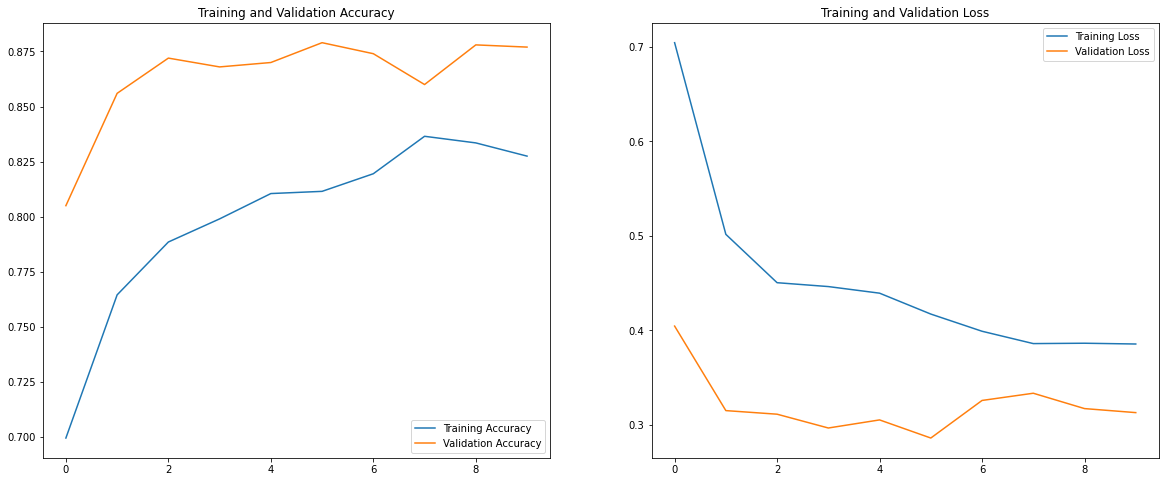

In [ ]:
acc = vgg16_hist.history['acc']
val_acc = vgg16_hist.history['val_acc']
loss = vgg16_hist.history['loss']
val_loss = vgg16_hist.history['val_loss']

range = range(eps)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(range, acc, label='Training Accuracy')
plt.plot(range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range, loss, label='Training Loss')
plt.plot(range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicted Labels (0 = cats, 1 = dogs):
 [1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1]
True Labels (0 = cats, 1 = dogs):
 [1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
Data:



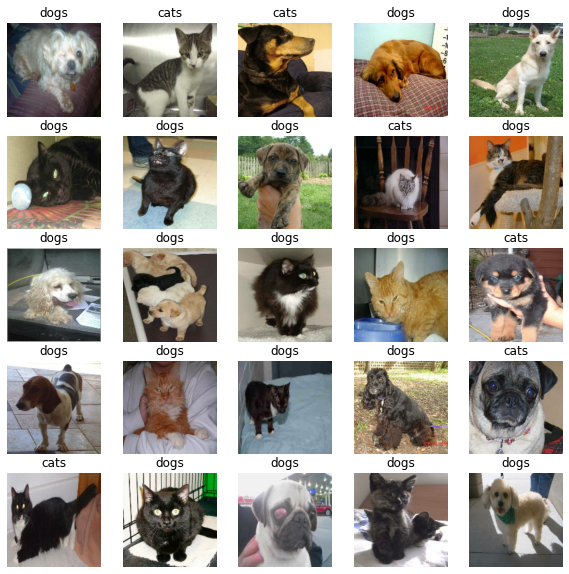

In [ ]:
# show the predictions and examples
label_nms = train_dataset.class_names

testX, testY = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(testX).flatten()
predictions = tf.nn.relu(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

#showing predicted list and true labels
print('Predicted Labels (0 = cats, 1 = dogs):\n', predictions.numpy())
print('True Labels (0 = cats, 1 = dogs):\n', testY)

print("Data:\n")

#showing actual data 
plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(testX[i].astype("uint8"))
  plt.title(label_nms[predictions[i]])
  plt.axis("off")